# Free boundary equilibrium

In [1]:
from desc import set_device
set_device("gpu")

from desc.backend import print_backend_info
print_backend_info()

import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    SplineMagneticField,
    field_line_integrate,
    FreeSurfaceOuterField,
)
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    FreeSurfaceError,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO

DESC version=0.15.0+420.g4b148fefb.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA A100-PCIE-40GB (id=0), with 40.00 GB available memory.


# vac stell source free

In [11]:
extcur = [4700.0, 1000.0]
ext_field = SplineMagneticField.from_mgrid(
    "/home/dpanici/DESC/tests/inputs/mgrid_test.nc", extcur=extcur
)

surf = FourierRZToroidalSurface(
    R_lmn=[0.70, 0.10],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-0.10],
    modes_Z=[[-1, 0]],
    NFP=5,
)

eq_init = Equilibrium(M=8, N=4, Psi=-0.035, surface=surf)
eq_init.solve();
eq2 = eq_init.copy()
from desc.magnetic_fields import SourceFreeField

constraints = (
    ForceBalance(eq=eq2),
    FixCurrent(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)
# THIS CELL IS CHANGED FROM REGULAR FREE BOUNDARY
free_out = SourceFreeField(eq2.surface, M=30, N=30, sym=False, B0=ext_field)
eval_grid = LinearGrid(M=30, N=30, NFP=eq2.NFP)
grid = LinearGrid(M=40, N=40, NFP=eq2.NFP)
objective = ObjectiveFunction(FreeSurfaceError(eq=eq2,
                                               field=free_out, 
                                               eval_grid=eval_grid,
                                               grid=grid,
                                               chunk_size=25,
                                               maxiter=45, jac_chunk_size=22))
      
# optimize
eq2, out = eq2.optimize(
    objective,
    constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,ftol=1e-3,
    options={"solve_options":{"ftol":1e-3}},x_scale="ess"
)

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 452
Number of objectives: 2754

Starting optimization
Using method: lsq-exact
`gtol` condition satisfied. (gtol=1.00e-08)
         Current function value: 1.048e-13
         Total delta_x: 1.743e-01
         Iterations: 13
         Function evaluations: 20
         Jacobian evaluations: 14
                                                                 Start  -->   End
Total (sum of squares):                                      1.940e-02  -->   1.048e-13, 
Maximum absolute Force error:                                9.735e+03  -

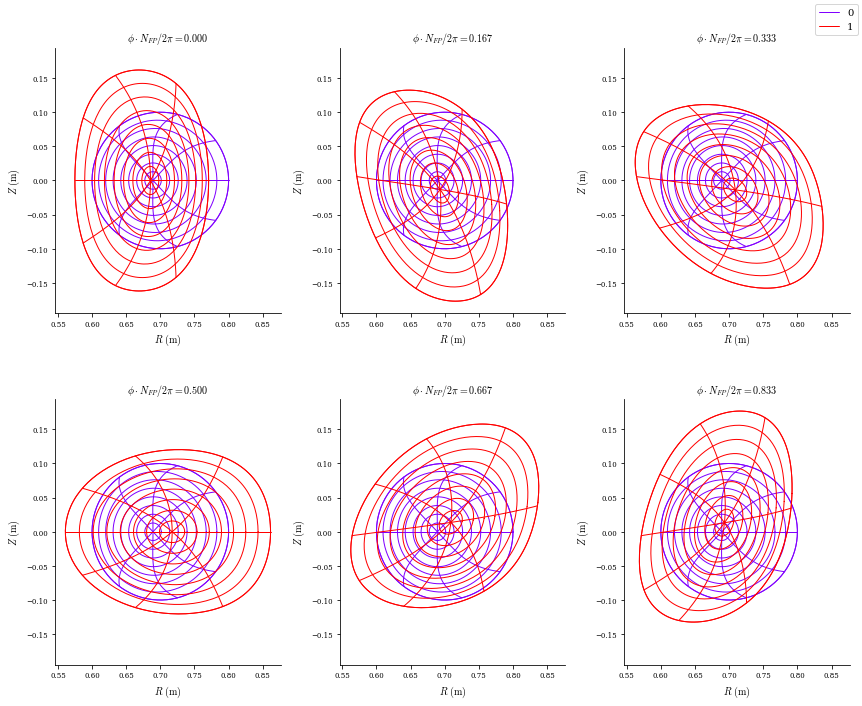

In [12]:
desc.plotting.plot_comparison([eq_init,eq2]);

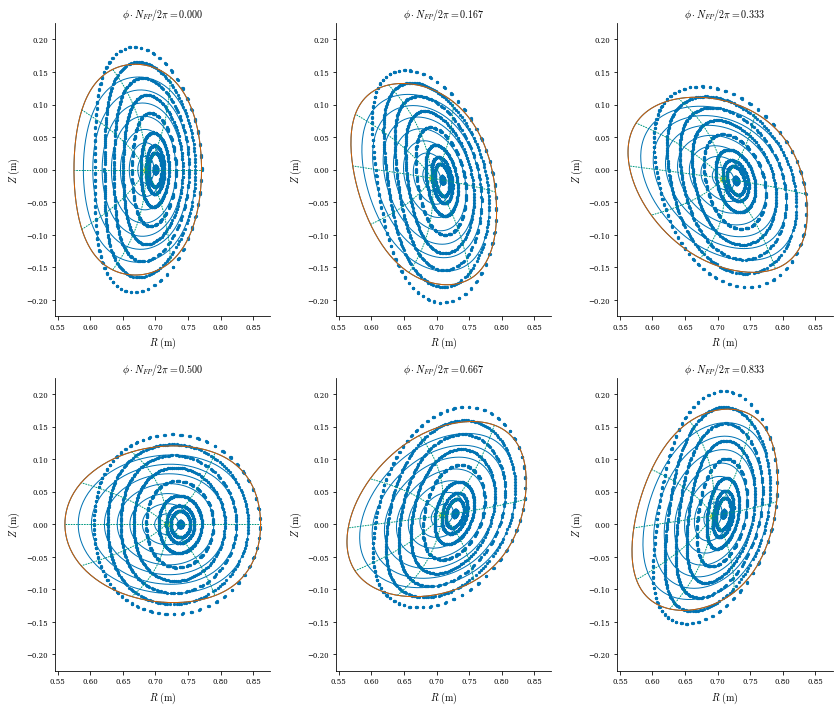

In [13]:
fig, ax = desc.plotting.plot_surfaces(eq2)

# for starting locations we'll pick positions on flux surfaces on the outboard midplane
grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
r0 = eq2.compute("R", grid=grid_trace)["R"]
z0 = eq2.compute("Z", grid=grid_trace)["Z"]

fig, ax = desc.plotting.poincare_plot(
    ext_field, r0, z0, ntransit=200, NFP=eq2.NFP, ax=ax
);